# Training a CNN classifier

By now you have learned about convolutional neural networks and regularization techniques. In this notebook, we will put everything together to train a convolutional network on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

In [1]:
# utility
import ipympl
import os
import pickle
from tqdm import tqdm
import yaml
from typing import Sequence, Union

# For interactive plotting:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass
try:
    %matplotlib widget
except:
    os.system('pip install ipympl -qq')
    %matplotlib widget


import torch
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision.transforms import v2

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'
print(f'Device: {Device}')


def save_yaml(config: dict, path: str):
    with open(path, 'w') as f:
        yaml.dump(config, f, sort_keys=False, default_flow_style=None)


def load_yaml(path: str):
    with open(path, 'r') as f:
        return yaml.load(f, Loader=yaml.FullLoader)


def print_tensor_info(
        name: str, 
        tensor, # torch.Tensor
        ):
    print(f'{name}')
    print(20*'-')
    if not isinstance(tensor, torch.Tensor):
        print(f'It is {type(tensor).__name__}!')
        print(20*'='+'\n')
        return
    # print name, shhape, dtype, device, require_grad
    print(f'shape: {tensor.shape}')
    print(f'dtype: {tensor.dtype}')
    print(f'device: {tensor.device}')
    print(f'requires_grad: {tensor.requires_grad}')
    print(20*'='+'\n')

Device: cuda


## Define and inspect the data

In [2]:
data_path = 'CIFAR10'

train_data = datasets.CIFAR10(
    root = data_path,
    train = True,
    download = True,
    transform = v2.Compose([
        v2.ToImage(),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True), # to [0, 1]
        v2.Lambda(lambda x: x-0.5), # to [-0.5, 0.5]
        ])
        )

test_data = datasets.CIFAR10(
    root = data_path,
    train = False,
    download = True,
    transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True), # to [0, 1]
        v2.Lambda(lambda x: x-0.5), # to [-0.5, 0.5]
        ])
        )


Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(train_data), len(test_data)

(50000, 10000)

In [4]:
x, y = train_data[39]
print_tensor_info('x', x)
print_tensor_info('y', y)

x
--------------------
shape: torch.Size([3, 32, 32])
dtype: torch.float32
device: cpu
requires_grad: False

y
--------------------
It is int!



In [5]:
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# helper class to visualize image data interactively in Jupyter Notebook
class ImageDataViz:
    """
    An interactive image data visualzation tool inside Juptyer Notebook.
    Make sure to use the magic command: %matplotlib widget
    """
    def __init__(self, data: Dataset):
        self.data = data
        self.n_samples = len(data)
        self.index = widgets.IntSlider(
            value=0, 
            min=0, 
            max=self.n_samples-1, 
            step=1, 
            description='Index', 
            continuous_update=True,
            layout=widgets.Layout(width='40%'),
            )

    def update(self, index: int):
        x, y = self.data[index]
        image = x.moveaxis(0, -1).squeeze().numpy()
        self.img.set_data(image)
        self.ax.set_title(f'Label: {cifar10_classes[y]}')

    def show(self):
        self.fig, self.ax = plt.subplots()
        x, y = self.data[0]
        image = x.moveaxis(0, -1).squeeze().numpy() # indexing the channel dimension with 0
        self.img = self.ax.imshow(image)
        self.ax.axis('off')
        self.ax.set_title(f'Label: {cifar10_classes[y]}')
        widgets.interact(self.update, index=self.index)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..0.5].


interactive(children=(IntSlider(value=0, description='Index', layout=Layout(width='40%'), max=49999), Output()…

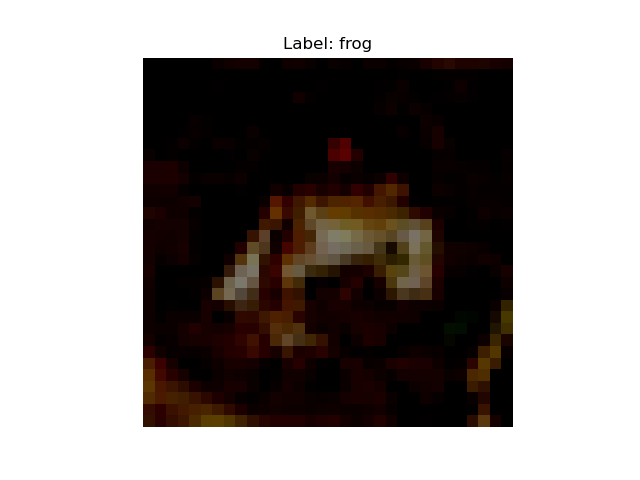

In [6]:
viz = ImageDataViz(train_data)
viz.show()

## Define the model

In [7]:
class CNN(nn.Module):

    def __init__(
        self,

        # Input and output information:
        input_shape: Sequence[int], # assumed to be (H, W) where H and W are powers of 2

        # Convolutional layers:
        conv_channels: Sequence[int],

        # Fully connected layers:
        fc_dims: Sequence[int] = [],
        ):
        super().__init__()

        # to keep track of the shape of data through the network:
        shape = list(input_shape)
        
        self.layers = nn.ModuleDict()

        # Convolutional layers:
        self.n_conv_layers = len(conv_channels)
        conv_channels = [3] + list(conv_channels)
        for i in range(self.n_conv_layers):
            self.layers[f'conv-{i:02d}'] = nn.Conv2d(
                in_channels = conv_channels[i],
                out_channels = conv_channels[i+1],
                kernel_size = 3,
                stride = 1,
                padding = 'same',
                )
            self.layers[f'conv-bn-{i:02d}'] = nn.BatchNorm2d(conv_channels[i+1])
            
            # keep track of the shape (we are going to do maxpooling with stride 2)
            shape = [s//2 for s in shape]
            assert all(s > 0 for s in shape), f'Invalid shape reached at layer {i}: {shape}'

        self.layers['conv-dropout'] = nn.Dropout2d(p=0.1)

        # Fully connected layers:
        self.n_fc_layers = len(fc_dims)
        fc_dims = [conv_channels[-1]*shape[0]*shape[1]] + list(fc_dims)
        for i in range(self.n_fc_layers):
            self.layers[f'fc-{i:02d}'] = nn.Linear(
                in_features = fc_dims[i],
                out_features = fc_dims[i+1],
                )
            self.layers[f'fc-bn-{i:02d}'] = nn.BatchNorm1d(fc_dims[i+1])

        self.layers['fc-dropout'] = nn.Dropout(p=0.1)

        self.layers['out'] = nn.Linear(fc_dims[-1], 10)

    def forward(
            self, 
            x: torch.FloatTensor, # input data of shape (batch_size, in_channels, H, W)
            ) -> torch.FloatTensor: # outputs logits of shape (batch_size, num_classes)

        for i in range(self.n_conv_layers):
            x = self.layers[f'conv-{i:02d}'](x)
            x = self.layers[f'conv-bn-{i:02d}'](x)
            x = F.relu(x)
            x = self.layers['conv-dropout'](x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = torch.flatten(x, start_dim=1) # (B, C, H, W) -> (B, C*H*W)

        for i in range(self.n_fc_layers):
            x = self.layers[f'fc-{i:02d}'](x)
            x = self.layers[f'fc-bn-{i:02d}'](x)
            x = F.relu(x)
            x = self.layers['fc-dropout'](x)

        x = self.layers['out'](x)

        return x

## Training and evaluation

In [8]:
@torch.enable_grad()
def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    device: str = Device,
    pbar: bool = False,
    ):
    if pbar:
        train_pbar = tqdm(
            train_loader,
            desc = 'training',
            unit = 'batch',
            leave = False,
        )
    else:
        train_pbar = train_loader

    model.train().to(device)

    for x, y in train_pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        if pbar:
            train_pbar.set_postfix_str(f'loss: {loss.item():.4f}')


@torch.inference_mode()
def eval_epoch(
    model: nn.Module,
    data_loader: DataLoader, # can be train_loader or val_loader or test_loader
    loss_fn: nn.Module,
    device: str = Device,
    pbar: bool = False,
    ):
    assert loss_fn.reduction in ['mean', 'sum'], 'Invalid reduction method!'
    if pbar:
        val_pbar = tqdm(
            data_loader,
            desc = 'evaluating',
            unit = 'batch',
            leave = False,
            )
    else:
        val_pbar = data_loader

    model.eval().to(device)
    
    n = 0
    Loss = 0.
    Accuracy = 0.

    for x, y in val_pbar:
        b = len(x)
        n += b
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        if loss_fn.reduction == 'mean':
            Loss += loss.item()*b
        elif loss_fn.reduction == 'sum':
            Loss += loss.item()

        Accuracy += (y_pred.argmax(dim=-1) == y).sum().item()
        if pbar:
            val_pbar.set_postfix_str(f'loss: {Loss/n:.4f}, accuracy: {Accuracy/n:.4f}')

    return Loss/n, Accuracy/n

In [9]:
class Tracker:
    """
    Logs training and validation loss and plots them in real-time in a Jupyter notebook.
    """
    def __init__(
            self, 
            n_epochs: int,
            plot_freq: int = 0, # plot every plot_freq epochs. 0 for no plotting
            ):
        self.train_losses = []
        self.test_losses = []
        self.train_accs = []
        self.test_accs = []
        self.epoch = 0
        self.n_epochs = n_epochs
        self.plot_freq = plot_freq
        if self.plot_freq > 0:
            self.plot_results()
        
        self.keys = ['train_losses', 'test_losses', 'train_accs', 'test_accs', 'epoch', 'n_epochs']

    def plot_results(self):
        self.fig, (self.loss_ax, self.acc_ax) = plt.subplots(1, 2, figsize=(16,6))

        xtickstep = max(1, self.n_epochs//10)
        xticks = list(range(0, self.n_epochs+1, xtickstep))
        if xticks[-1] != self.n_epochs:
            xticks.append(self.n_epochs)

        # Loss plot:
        self.train_curve, = self.loss_ax.plot(
            range(1, self.epoch+1), 
            self.train_losses,
            'o-', 
            label = 'train',
            )
        self.val_curve, = self.loss_ax.plot(
            range(1, self.epoch+1), 
            self.test_losses, 
            'o-',
            label = 'test'
            )
        self.loss_ax.set_xlim(0, self.n_epochs+1)
        self.loss_ax.set_xlabel('Epoch')
        self.loss_ax.set_xticks(xticks)
        self.loss_ax.set_ylabel('Loss')
        self.loss_ax.set_title('Loss Learning Curve')
        self.loss_ax.legend(loc='upper right')
        self.loss_ax.grid(linestyle='--')
        self.loss_text = self.loss_ax.text(1.01, 1.0, '', transform=self.loss_ax.transAxes, va='top', ha='left')

        # Accuracy plot:
        self.train_acc_curve, = self.acc_ax.plot(
            range(1, self.epoch+1),
            self.train_accs, 
            'o-',
            label = 'train',
            )
        self.val_acc_curve, = self.acc_ax.plot(
            range(1, self.epoch+1), 
            self.test_accs, 
            'o-',
            label = 'test',
            )
        self.acc_ax.set_xlim(0, self.n_epochs+1)
        self.acc_ax.set_xlabel('Epoch')
        self.acc_ax.set_xticks(xticks)
        self.acc_ax.set_ylabel('Accuracy')
        self.acc_ax.set_title('Accuracy Learning Curve')
        self.acc_ax.legend(loc='lower right')
        self.acc_ax.grid(linestyle='--')
        self.acc_text = self.acc_ax.text(1.01, 1.0, '', transform=self.acc_ax.transAxes, va='top', ha='left')

    def update(
            self, 
            train_loss: float, 
            test_loss: float, 
            train_acc: float, 
            test_acc: float,
            ):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        self.train_accs.append(train_acc)
        self.test_accs.append(test_acc)
        self.epoch += 1
        if self.plot_freq and self.epoch % self.plot_freq == 0:

            # loss plot:
            self.train_curve.set_data(range(1, self.epoch+1), self.train_losses)
            self.val_curve.set_data(range(1, self.epoch+1), self.test_losses)
            self.loss_ax.relim()
            self.loss_ax.autoscale_view()
            self.loss_ax.set_ylim(bottom=0.0, top=None)
            self.loss_text.set_text(f'Epoch {self.epoch}\n' + 20*'-' + '\n' + f'Train Loss: {train_loss:.4f}\nTest Loss: {test_loss:.4f}')

            # accuracy plot:
            self.train_acc_curve.set_data(range(1, self.epoch+1), self.train_accs)
            self.val_acc_curve.set_data(range(1, self.epoch+1), self.test_accs)
            self.acc_ax.relim()
            self.acc_ax.autoscale_view()
            self.acc_ax.set_ylim(bottom=None, top=1.0)
            self.acc_text.set_text(f'Epoch {self.epoch}\n' + 20*'-' + '\n' + f'Train Acc: {train_acc:.4f}\nTest Acc: {test_acc:.4f}')

            plt.tight_layout()
            self.fig.canvas.draw()
            clear_output(wait=True)
            display(self.fig)

    def save_results(self, path: str):
        # saving losses and accuracies with pickle
        with open(path, 'wb') as file:
            pickle.dump({key: getattr(self, key) for key in self.keys}, file)

    def load_results(self, path: str):
        # loading losses and accuracies with pickle
        with open(path, 'rb') as file:
            results = pickle.load(file)
            for key, value in results.items():
                setattr(self, key, value)

In [12]:
def train(
    # Model and data
    save_path: str,
    model: nn.Module,
    train_data: Dataset,
    test_data: Dataset,

    # Loss and optimizer
    loss_fn: nn.Module, # from nn
    optim_name: str, # from optim
    optim_config: dict = dict(),
    lr_scheduler_name: Union[str, None] = None, # from lr_scheduler
    lr_scheduler_config: dict = dict(),

    # training settings:
    n_epochs: int = 10,
    batch_size: int = 32,
    device: str = Device,

    # progress bar and plotting:
    train_pbar: bool = False,
    val_pbar: bool = False,
    plot_freq: Union[int, None] = 5,
    save_freq: Union[int, None] = None,
    ):

    if save_freq == 0:
        save_freq = n_epochs
        
    os.makedirs(f'{save_path}/checkpoints', exist_ok=True)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    optimizer: optim.Optimizer = optim.__getattribute__(optim_name)(model.parameters(), **optim_config)
    if lr_scheduler_name is not None:
        scheduler: lr_scheduler._LRScheduler = lr_scheduler.__getattribute__(lr_scheduler_name)(optimizer, **lr_scheduler_config)

    epoch_pbar = tqdm(
        range(1, n_epochs+1),
        desc = 'epochs',
        unit = 'epoch',
        dynamic_ncols = True,
        leave = True,
        )

    tracker = Tracker(n_epochs, plot_freq=plot_freq)

    for epoch in epoch_pbar:

        train_epoch(
            model = model,
            train_loader = train_loader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            device = device,
            pbar = train_pbar,
            )

        train_loss, train_acc = eval_epoch(
            model = model,
            data_loader = train_loader,
            loss_fn = loss_fn,
            device = device,
            pbar = val_pbar,
            )

        test_loss, test_acc = eval_epoch(
            model = model,
            data_loader = test_loader,
            loss_fn = loss_fn,
            device = device,
            pbar = val_pbar,
            )

        if lr_scheduler_name == 'ReduceLROnPlateau':
            scheduler.step(train_loss)
        elif lr_scheduler_name is not None:
            scheduler.step()

        tracker.update(train_loss, test_loss, train_acc, test_acc)

        if epoch % save_freq == 0:
            torch.save(model.state_dict(), f'{save_path}/checkpoints/epoch_{epoch}.pt')
            tracker.save_results(f'{save_path}/results.pkl')

## Specify model and training config

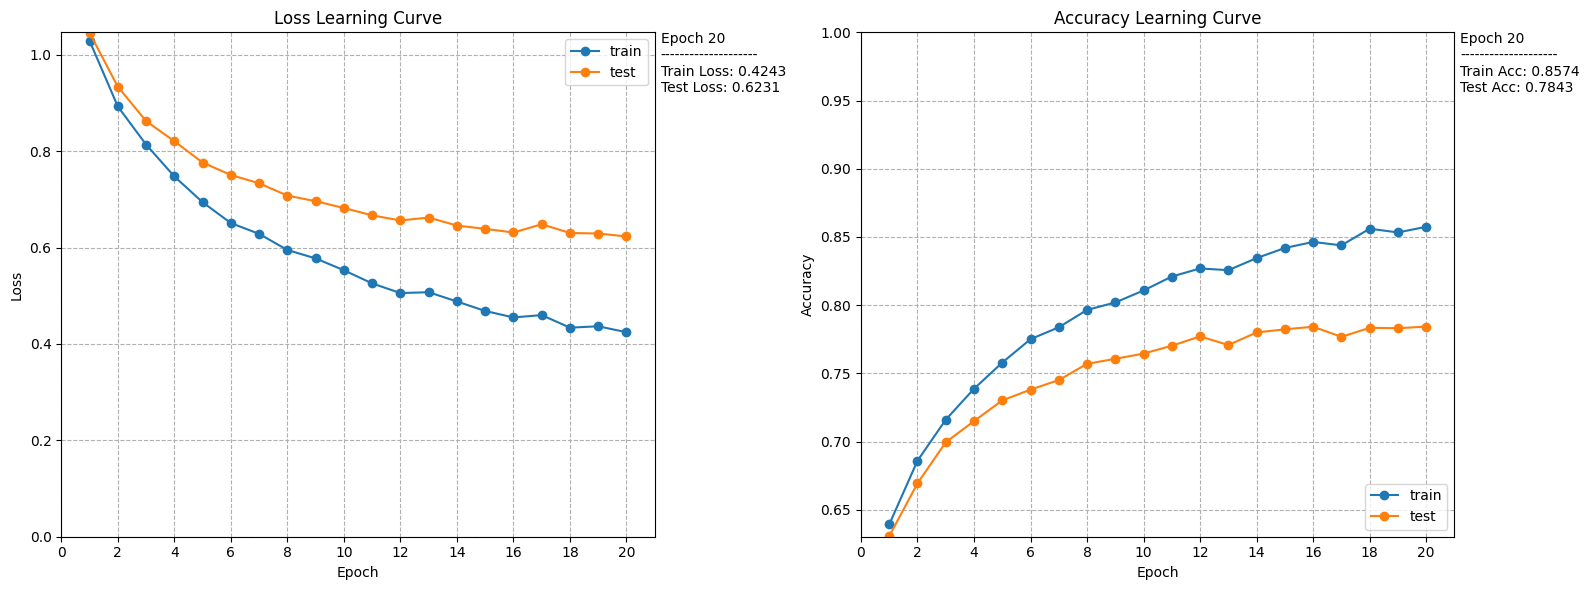

epochs: 100%|██████████| 20/20 [14:55<00:00, 44.79s/epoch]


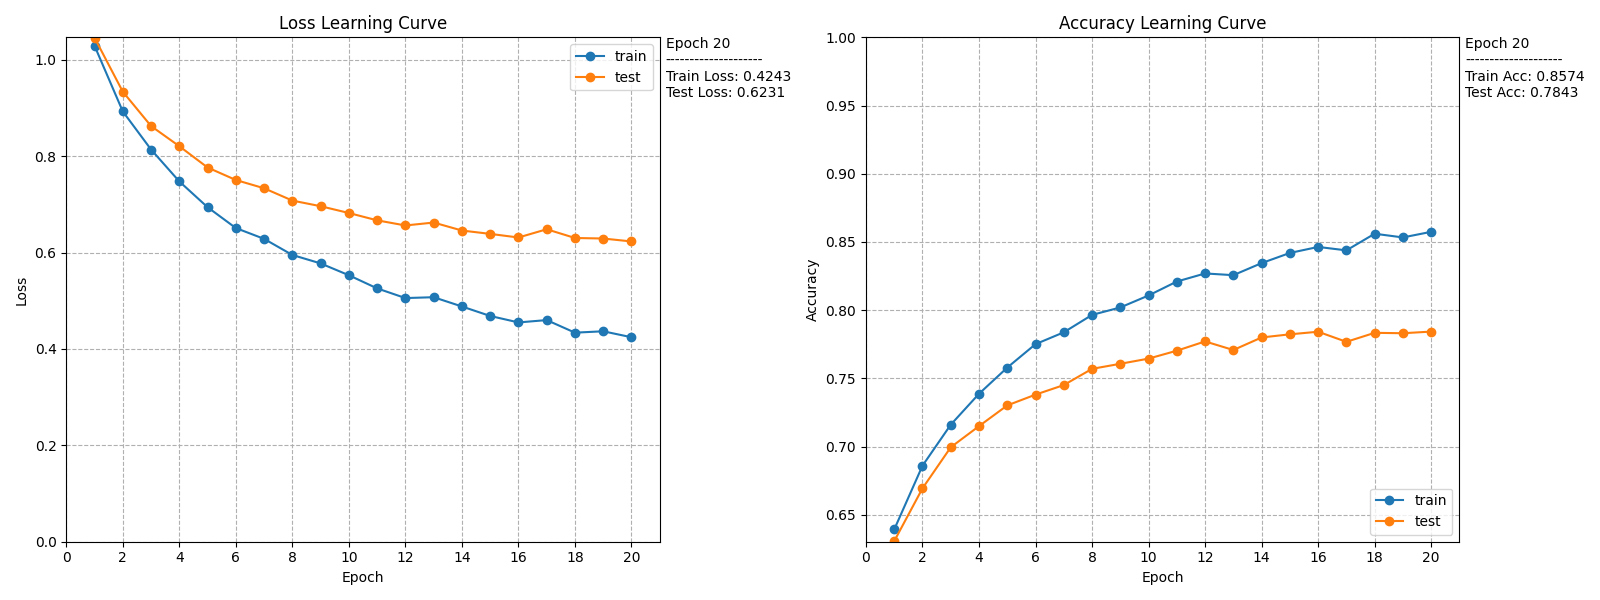

In [13]:
# creating a folder to save the results
results_dir = 'week4-results'
os.makedirs(results_dir, exist_ok=True)

model_config = dict(
    input_shape = (32, 32),
    conv_channels = [16, 32, 64],
    fc_dims = [128],
    )

train_config = dict(
    optim_name = 'Adam',
    optim_config = dict(lr=1e-3, weight_decay=1e-5),
    lr_scheduler_name = None,
    lr_scheduler_config = dict(),
    n_epochs = 20,
    batch_size = 64,
    )

# create a folder to save the configs, model checkpoints, and results:
n_experiments = len(os.listdir(results_dir))
name = f'{n_experiments:02d}' # automatic
# name = 'My_best_try'
save_path = f'{results_dir}/{name}'
os.makedirs(save_path, exist_ok=False) # make sure to not overwrite existing results
save_yaml(model_config, f'{save_path}/model_config.yaml')
save_yaml(train_config, f'{save_path}/train_config.yaml')

model = CNN(**model_config)
train(
    save_path = save_path,
    model = model,
    train_data = train_data,
    test_data = test_data,
    loss_fn = nn.CrossEntropyLoss(),
    train_pbar = False,
    val_pbar = False,
    device = Device,
    plot_freq = 1,
    save_freq = 1,
    **train_config,
    )

## Loading the model and results

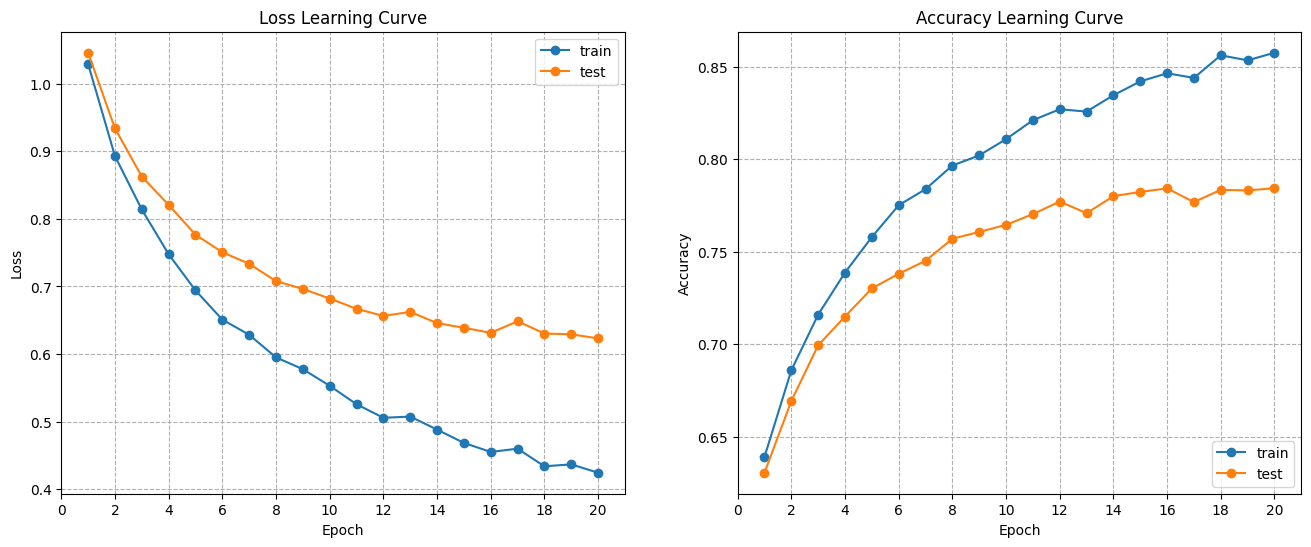

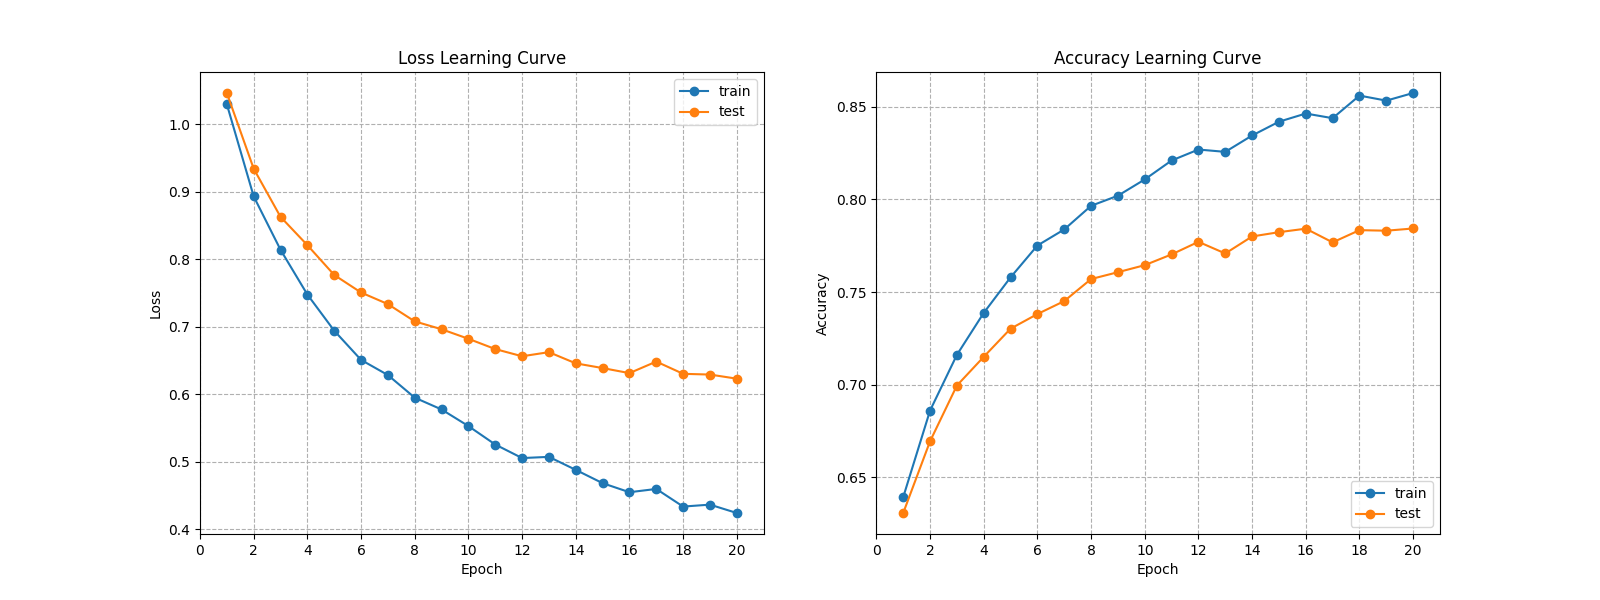

In [14]:
name = '00'

# load the model config:
model_config = load_yaml(f'{results_dir}/{name}/model_config.yaml')

# create a new model with the same configuration:
model = CNN(**model_config).to(Device)

# load the results with a new tracker:
tracker = Tracker(0)
tracker.load_results(f'{results_dir}/{name}/results.pkl')

# load the model state dict:
state_dict = torch.load(f'{results_dir}/{name}/checkpoints/epoch_{tracker.epoch}.pt', map_location=Device)
model.load_state_dict(state_dict)

# see what the results were:
tracker.plot_results()
clear_output(wait=True)
display(tracker.fig)